# Lab 1: Detecting type of motion through clustering

Natalia Kisanga, Cho Yin Kong, Lucy Newman

---

In this lab, we collected motion data from a car in one of four possible conditions: Walking, Jumping, Driving, or Standing. The goal was to analyze these acceleration, gyroscope, and magnetism measurements, in order to train a model that can predict which of those four actions was being done in a new log.

After collecting the data, we began by parsing the logs and putting them into a Log class in python. In addition to parsing, the class has methods for plotting a log and also for obtaining a set of values for each measurement that we will use for training the model.

# Parsing and analysis

In [16]:
from pylab import fft
from nfft import ndft
from math import sqrt
import ast
import pprint
import matplotlib.pyplot as plt
import numpy as np
import operator
import peakutils
import os

class Log:
    measurements = ["xAccl","yAccl","zAccl","xGyro","yGyro","zGyro","xMag","yMag","zMag"]
    types = ["Jumping", "Standing", "Walking", "Driving"]

    def __init__(self, rawdata):
        """
        Accepts raw json accelerometer measurements. Assigns a type (Walking,
        Jumping, Driving, Standing, Unknown) to an attribute and assigns the
        array of times to an attribute, as well as an array for the values
        collected for each measurement.
        """
        if isinstance(rawdata, basestring):
            rawdata = ast.literal_eval(rawdata)

        self.type = rawdata['type']

        times = []
        time0 = rawdata['seq'][0]['time']
        for y in rawdata['seq']:
            times.append((y['time'] - time0))
        self.times = times

        for ylabel in self.measurements:
            m = []
            for z in rawdata['seq']:
                m.append(z['data'][ylabel])
            self.__dict__[ylabel] = m

    def __str__(self):
        """prints a human-readable version of the Log object"""
        ret = ""
        ret += "Type: %s\n" % (self.type)
        t = self.times
        if len(t) < 4:
            return
        ret += "Times:\n\t[%s,%s,%s,...,%s]\n" % (t[0],t[1],t[2],t[-1])
        for y in self.measurements:
            m = self.__dict__[y]
            ret += "%s:\n\t[%s,%s,%s,...,%s]\n" % (y,m[0],m[1],m[2],m[-1])
        return ret
    
    def getMeasurements(self, ylabel):
        """Gets a list of measurements as input into our KMeans algorithm"""
        ys = self.__dict__[ylabel]
        ymax = max(ys)
        ymin = min(ys)
        return [ymax, ymin]
    
    def calcSpeed(self):
        """Calculates speed by averaging over the calculated speed from every 2 points"""
        vmags = []
        for i in range(len(self.times) - 1):
            xv = sp.integrate.simps([self.__dict__["xAccl"][i], self.__dict__["xAccl"][i+1]], [self.times[i], self.times[i+1]])
            yv = sp.integrate.simps([self.__dict__["yAccl"][i], self.__dict__["yAccl"][i+1]], [self.times[i], self.times[i+1]])
            zv = sp.integrate.simps([self.__dict__["zAccl"][i], self.__dict__["zAccl"][i+1]], [self.times[i], self.times[i+1]])
            vmags.append(sqrt(xv**2 + yv**2 + zv**2))
        return np.average(vmags)

    def showPlot(self): 
        """plot the logs and their associated frequencie estimations"""
        i=1
        plt.figure(1).set_size_inches(24,48)
        for ylabel in self.measurements:
            m = self.__dict__[ylabel]
            plt.subplot(len(self.measurements),2,i)
            i += 1   
            plt.plot(self.times,m,label=ylabel)
            plt.xlabel('Time (s)')
            plt.title("magnitude for %s %s" % (self.type, ylabel))
            plt.grid(True)
            i += 1 
        plt.tight_layout()
        plt.show()

We then added some functions for reading and parsing the files into a dictionary.

In [3]:
def parseFile(filepath):
    """parse a single file containing an array of logs"""
    with open(filepath) as f:
        rawdata = f.read()
    rawdata = ast.literal_eval(rawdata)
    logs = []
    for rd in rawdata:
        log = Log(rd)
        logs.append(log)
    return logs

def parseTestFolder(folderpath):
    """parses the test files given to us which each contain a dictionary"""
    logs = []
    for file in os.listdir(folderpath):
        filepath = os.path.join(folderpath, file)
        with open(filepath) as f:
            rawdata = ast.literal_eval(f.read())
            logs.append(Log(rawdata))
    return logs

def parseFolder(folderpath):
    """parses a folder of files, each containing an array of logs"""
    logs = []
    for file in os.listdir(folderpath):
        filepath = os.path.join(folderpath, file)
        logs += parseFile(filepath)
    return logs

def parseFolderSelected(folderpath, types):
    """parses only the folders whose names contain the desired types"""
    logs = []
    for file in os.listdir(folderpath):
        for t in types: 
            if t in file:
                filepath = os.path.join(folderpath, file)
                logs += parseFile(filepath)
                continue
    return logs


We also wrote code to compute the speeds for a given folder that contains the test data.

In [1]:
def getSpeeds(folder):
    test_logs = parseTestFolder(folder)
    speeds = []
    for log in test_logs:
        speeds.append(log.calcSpeed())
    return speeds

We began analyzing the data by first looking at some graphs, created by the `showPlot` method in the `Log` class above. Seeing the visual differences between the various types of data helped us think about what features we might want to include in our model. For example, in the sample plots below, we see one point for driving and one for jumping. There are clear visual differences in the amplitude and in the period.

# Graphing

## Jumping Graphs

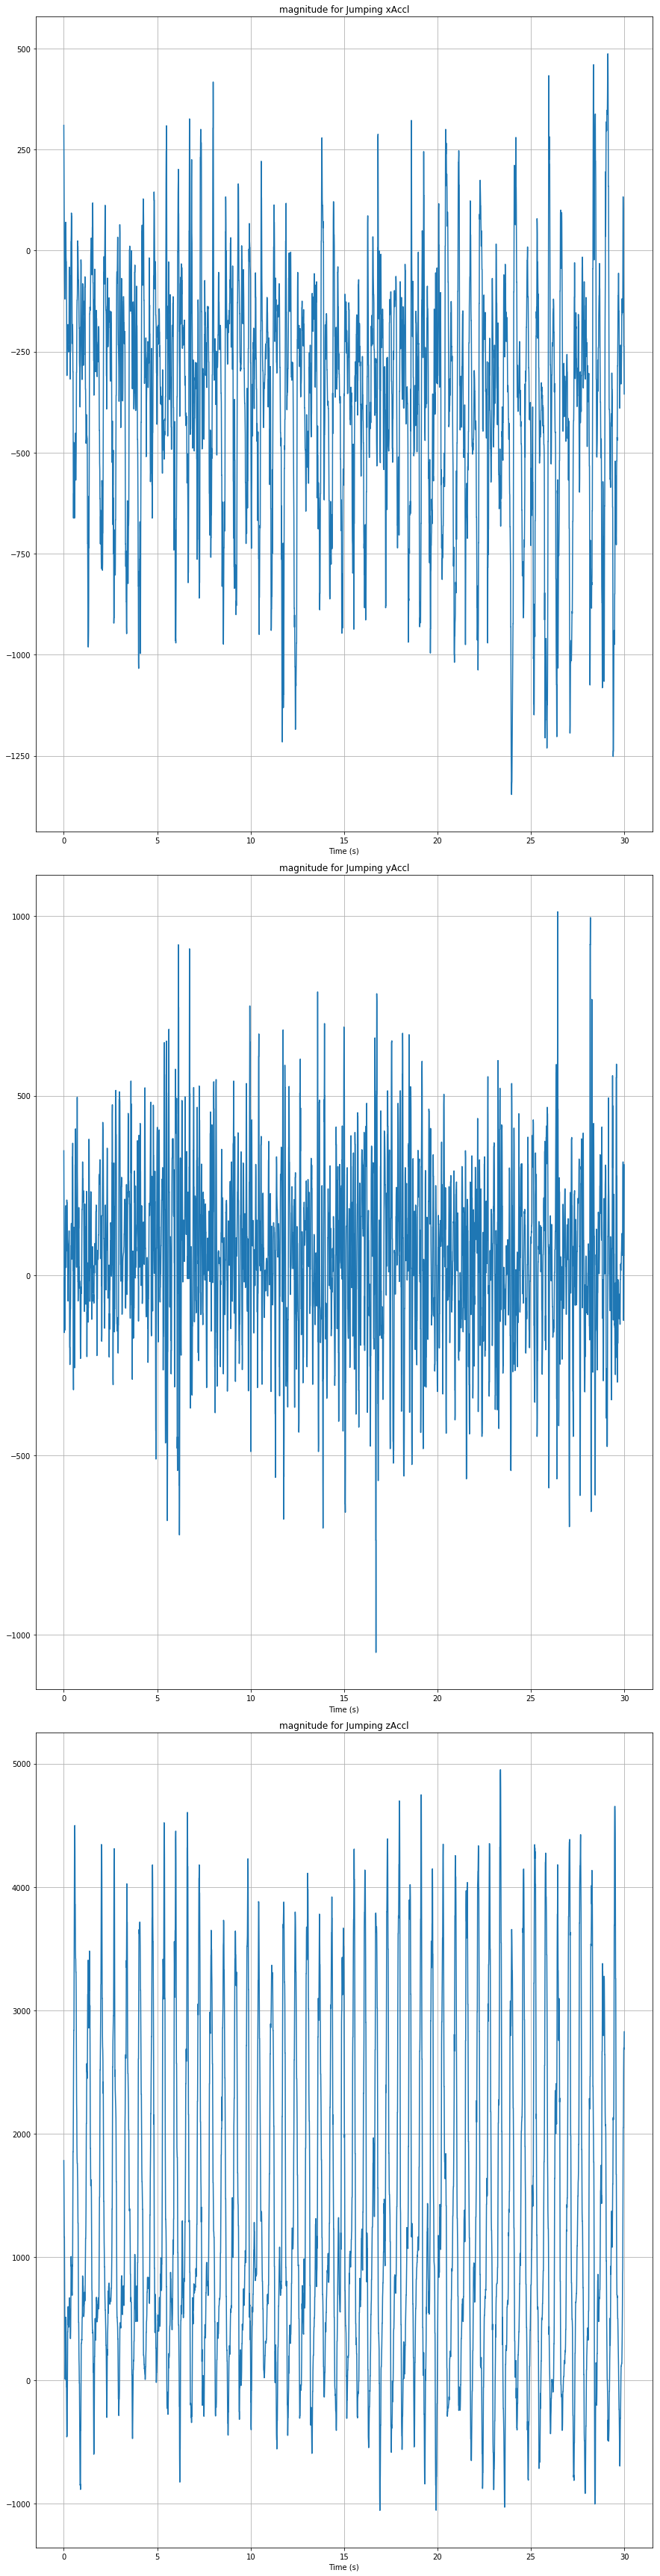

## Standing Graphs

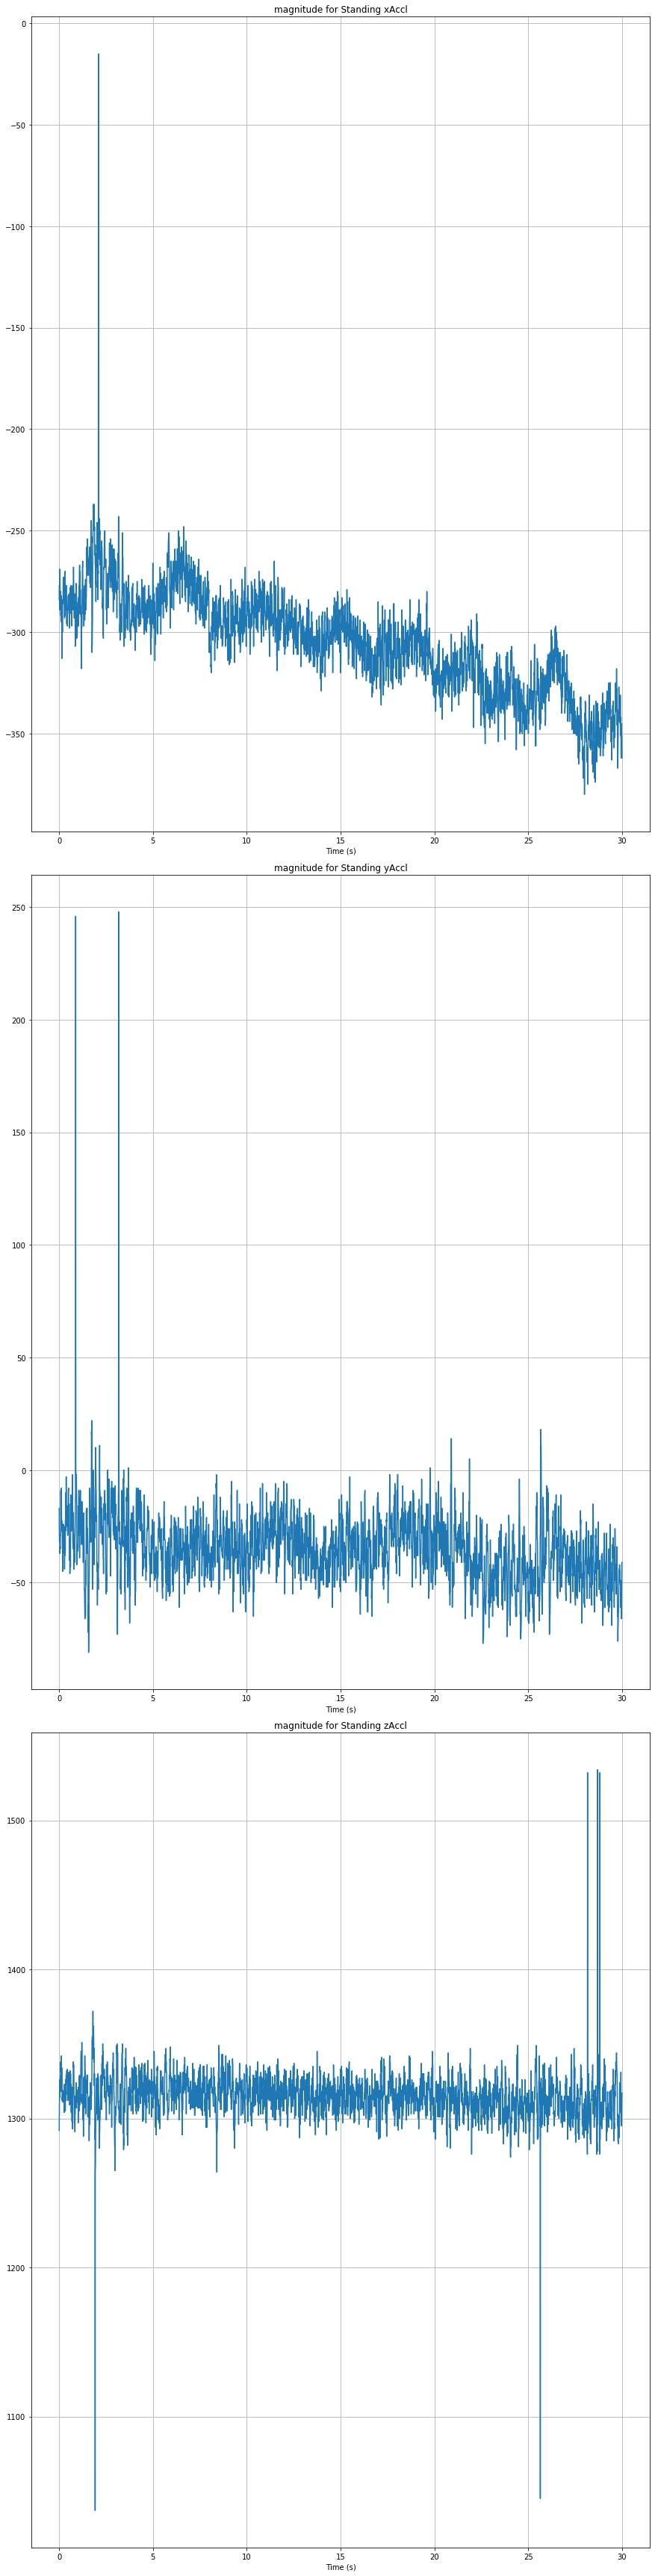

## Driving Graphs

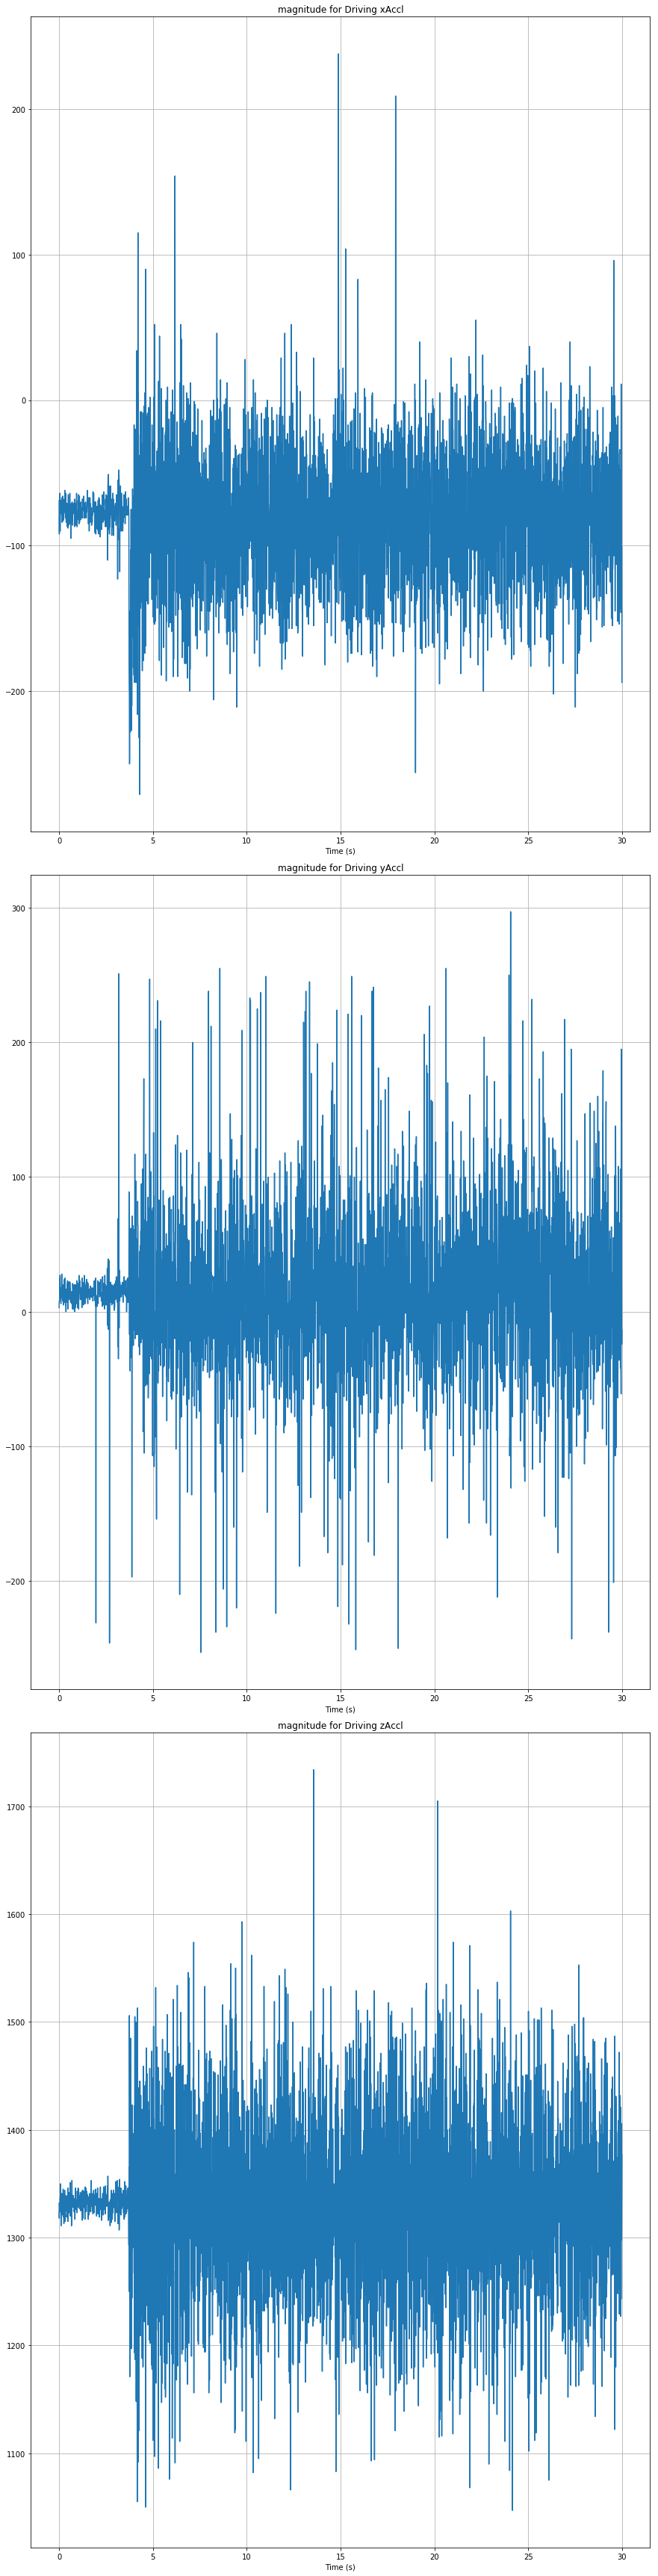

## Walking Graphs

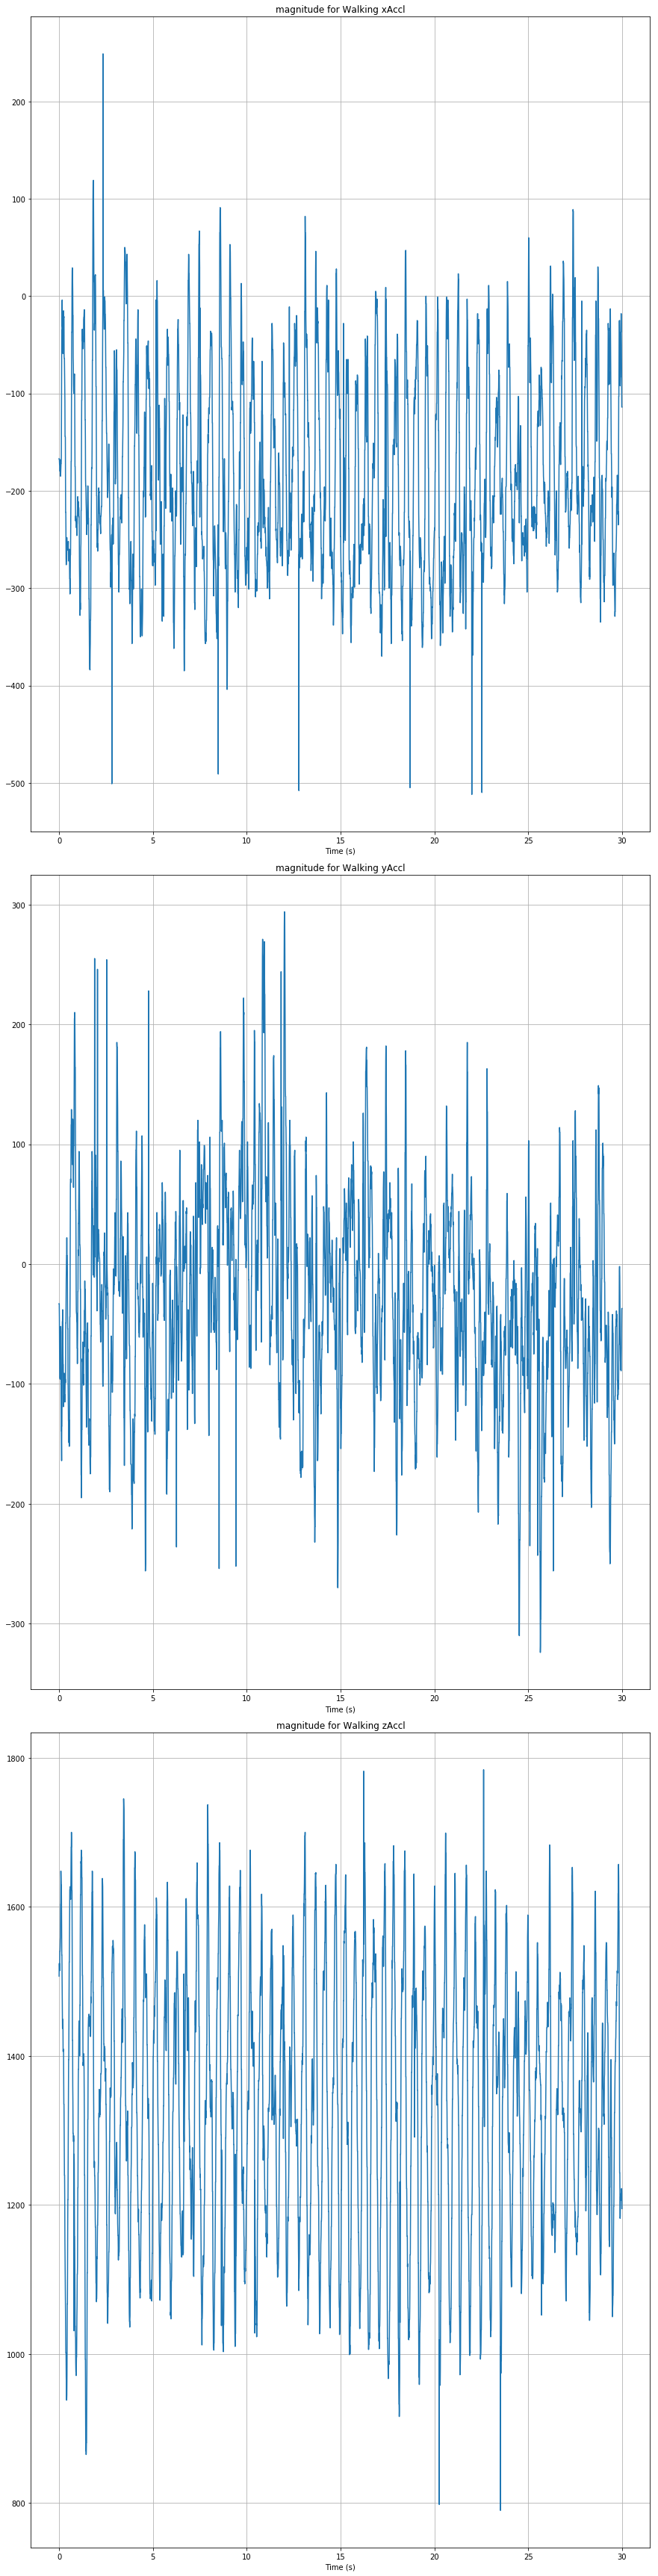

In [17]:
from IPython.display import display, Markdown

def displayFile(filepath, type):
    display(Markdown("## %s Graphs" % type))
    with open(filepath) as f:
        rawdata = f.read()
    log = Log(rawdata)
    log.showPlot()

displayFile("logs/activity-team2-Jumping-0.txt", "Jumping")
displayFile("logs/activity-team2-Driving-0.txt", "Driving")

# Designing the model

We observed that the range of values, and the period, are significantly more different accross different measurement types as compared within types. This is how we settled on using `ymin`, `ymax`, and the number of "peaks" (as an approximation for period) in our model. 

We began working on our model by writing some functions that would help us determine which set of measurements would be best. This allows us to play around with what values we want to use for each measurement.

In [12]:
from sklearn.cluster import KMeans
import numpy as np

def testMultipleVars(logs, ylabels):
    """
    given multiple variables, we test the current model's results 
    when clustering with these variables.
    """
    points = map(lambda x: x.getMultipleMeasurements(ylabels), logs)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(points)
    labels = kmeans.labels_
    return labels

def checkGroundTruth(logs, labels, expected):
    """
    comparing the clustering results to the ground truth
    """
    if sum(labels) > len(labels) // 2:
        for i in range(len(labels)):
            labels[i] = 1 - labels[i]
    res = {}
    if (len(logs) != len(labels)):
        return 
    for i in range(len(logs)):
        unexpected = 1
        if logs[i].type == expected and labels[i] == 1:
            unexpected = 0
        if logs[i].type != expected and labels[i] == 0:
            unexpected = 0
        if logs[i].type in res:
            res[logs[i].type] += unexpected
        else:
            res[logs[i].type] = unexpected
    return res

def perfectFit(logs, labels, expected):
    """
    checking whether set of measurements provides a model that is a perfect
    fit.
    """
    groundTruth = checkGroundTruth(logs, labels, expected)
    for g in groundTruth:
        if groundTruth[g] != 0:
            return False
    return True

def checkCombos(logs, categories):
    """
    checking each combination of measurements, we return one with a smallest
    number of variables that is correct, if one exists
    """
    for expected in categories:
        for i in range(1,len(Log.measurements) + 1):
            for ylabels in combinations(np.array(Log.measurements), i):
                labels = testMultipleVars(logs, ylabels)
                if perfectFit(logs, labels, expected):
                    print(expected, ylabels)
                    return expected, ylabels

## With gyroscope, magnetism, and acceleration data

Using these functions, we obtained a set of measurements that we would use to make our predictions. As we continued to improve the set of values we got from each log, we would use these functions to see how well it works. 

Our set of measurements was the minimum and maximum of each trace, `["ymin", "ymax"]`. We ran through many other kinds of measurements, such as standard deviation, but the results were either equally or less accurate than just these two measurements.

We computed these measurements for every trace in a given folder. We then ran all these traces through KMeans, and took the measurements of the predicting point to predict whether it was in cluster 0 or 1. We saw the best results when we used KMeans with 2 clusters instead of 4, so we would have to predict each category separately. 

We used `['xGyro', 'xAccl', 'zAccl']` to separate out results that would return `"Jumping"`. Then, we took out all the datapoints from all the data that was `"Jumping"`. Then, we used `['xMag', 'yMag', 'yGyro', 'yAccl']` to extract the results that were `"Standing"`

Using only `ymin` and `ymax`, we were able to separate Driving from Walking using six different measurements (`['xGyro', 'yGyro', 'zAccl', 'yAccl', 'zGyro', 'zMag']`). 

When we added peak estimation, we brought this down to two measurements, `xGyro` and `yAccl`. We believe that a minimal model is best since this impoves efficiency and space requirements, so we saw this as an improvement.

In [13]:
def comboMeas(log, measArr):
    points = []
    for ylabel in measArr:
        points += log.getMeasurementInfo(ylabel)
    return points

def getPrediction(log, folder, categories, ylabels):
    """Gets all the measurement info for all the data points in the folder, and uses them in Kmeans.
    Then, gets the measurements for the point we're predicting and predicts it with KMeans"""
    logs = parseFolderSelected(folder, categories)
    points = map(lambda x: comboMeas(x, ylabels), logs)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(points)
    point = comboMeas(log, ylabels)
    prediction = kmeans.predict([point])
    return prediction[0]

def predictNewPoint(point, folder):
    """Determine which category a new point/trace falls into"""
    categories = Log.types
    prediction = getPrediction(point, folder, categories, \
        ['xGyro', 'xAccl', 'zAccl'])
    if prediction == 1:
        return "Jumping"
    categories.remove("Jumping")
    prediction = getPrediction(point, folder, categories, \
        ['xMag', 'yMag', 'yGyro', 'yAccl'])
    if prediction == 0:
        return "Standing"
    categories.remove("Standing")
    prediction = getPrediction(point, folder, categories, \
        ['yAccl', 'xGyro'])
    if prediction == 1:
        return "Walking"
    if prediction == 0:
        return "Driving"


Our measurements for each trace was `["ymin", "ymax"]`.

When we used all the points from everyone's combined datasets, and tested each point from the same dataset against it, we had 1 wrong result, out of 90 data points, so we had a 98.89% accuracy.

However, these measurements and this accuracy was only if we added the Gyro and Mag data.

## With just acceleration data

We then tried to run the predictions with only acceleration data to make our predictions. This is because the significant physical differences between these actions should be most related to acceleration, and differences in gyroscope or magnetism may be an unintended consequence of the way the data is collected, that we cannot rely on. Using the `checkAllCombos` and `getBestThreshold` functions above, we were able to obtain a set of measurements that lead to 13 incorrect predictions, or an 85.5% accuracy rate. The algorithm below uses `getPredictionFast`, which is explained in the "Speeding up our our algorithm" section below.


In [ ]:
def predictNewPointAcclOnly(log, points, ylabels, all_points, ts, ms1, ms2, ms3):
    """algorithm for predicting a new point using acceleration only"""
    types = Log.types[:]
    point = log.getMultMeasFast(ylabels, ts[0])
    prediction = getPredictionFast(point, points, ylabels, ms1)
    if prediction == 1:
        return "Jumping"
    types.remove("Jumping")
    points = getRightLogs(all_points, types)
    point = log.getMultMeasFast(ylabels, ts[1])
    prediction = getPredictionFast(point, points, ylabels, ms2)
    if prediction == 1:
        return "Driving"
    types.remove("Driving")
    points = getRightLogs(all_points, types)
    point = log.getMultMeasFast(ylabels, ts[2])
    prediction = getPredictionFast(point, points, ylabels, ms3)
    if prediction == 1:
        return "Standing"
    if prediction == 0:
        return "Walking"

In our Log class, we made some changes to the measurements that would be used to calculate on each trace, rather than only using the minimum and maximum values of each trace. We first filtered out the data using the Savitzky–Golay filter to get rid of some noise, then we calculated the number of peaks in a trace, as a measure of periods.

To separate out `"Jumping"`, we used a `threshold=0`. 
To separate out `"Driving"`, we used a `threshold=0.2`. 
To separate out `"Standing"` from `"Walking"`, we used a `threshold=0.5`. 

When we ran this function on our algorithm that utilised all the magnetism and gyrometer data, we couldn't improve our accuracy. However, it improved our accuracy on our acceleration-only-based algorithm and we got from 15 wrong values to 13 wrong values. 

In [3]:
def getNumPeaks(self, ylabel, thres):
    ys = np.array(self.__dict__[ylabel])
    ys = savgol_filter(ys, 5, 4)
    indexes = np.array(peakutils.indexes(ys, thres=thres))
    return len(indexes)

def getMeasurementInfo(self, ylabel, thres):
    ys = self.__dict__[ylabel]
    ymax = max(ys)
    ymin = min(ys)
    numPeaks = self.getNumPeaks(ylabel, thres)
    return [ymax, ymin, numPeaks]

## Attempts to improve our algorithm

We tried to improve our accuracy by adding different kinds of measurements other than the minimum and maximum values. However, many of them either didn't improve our accuracy, or worsened our accuracy. These were some of the functions we tried:

In [ ]:
def getMax(self, ylabel):
    """Gets maximum value but without some outliers"""
    ys = self.__dict__[ylabel][:]
    for i in range(10):
        ys.remove(max(ys))
    return max(ys)

def getMin(self, ylabel):
    """Gets minimum value but without some outliers"""
    ys = self.__dict__[ylabel][:]
    for i in range(10):
        ys.remove(min(ys))
    return min(ys)

def getFreq(self, ys):
    """Gets maximum magnitude of a frequency using the Fast Fourier Transform"""
    yf = fft(np.array(ys[:(len(ys)//2)]))
    return np.max(yf)

def getFreqNew(self, ys, times):
    """Gets maximum magnitude of a frequency using the 
    Non-uniform Discrete Fourier Transform, since our time points are uneven"""
    length = len(times)//2
    if length % 2 != 0:
        length = length - 1
    amps = ndft(times[:length], ys[:length])
    return np.max(amps)

def getMeasurementInfo(self, ylabel, thres):
    ys = self.__dict__[ylabel]
    ymax = max(ys)
    ymin = min(ys)
    numPeaks = self.getNumPeaks(ylabel, thres)
    return [ymax, 
            ymin, 
            numPeaks,
            #standard deviation of the values
            np.std(ys),
            #average of all the values
            np.average(ys),
            self.getFreq(ys),
            self.getFreqNew(ys, xs)
           ]

## Speeding up our algorithm

However, this function is inefficient and took a long time to run, because it computed the same measurements from the same points. 

We rewrote our code so that it was significantly faster to run, as it computes all the necessary measurements in the beginning and indexes them so that we could use the values when we needed to.

In [14]:
def parseFolderSelectedFast(folderpath, types):
    """Parses folder in a different format than before """
    logs = {}
    for file in os.listdir(folderpath):
        curr_types = []
        for t in types:
            if t in file:
                filepath = os.path.join(folderpath, file)
                curr_types += parseFile(filepath)
                logs[t] = curr_types
    return logs

def getRightLogs(all_points, types):
    """Selects the right datapoints and flattens them into a list"""
    logs = []
    for key in all_points:
        if key in types:
            logs += all_points[key]
    return logs

def comboMeasFast(log, measArr):
    """Get the measurements for each trace"""
    points = []
    for ylabel in measArr:
        points += [log.getMeasurementInfo(ylabel)]
    return points

def getPredictionFast(point, all_points, all_ylabels, ylabels):
    """Runs the Kmeans algorithm with 2 clusters and uses it to 
    predict the given point"""
    indexes = []
    for y in ylabels:
        for i, ylabel in enumerate(all_ylabels):
            if y == ylabel:
                indexes.append(i)
    new_points = []
    for i in all_points:
        temp = []
        for x in indexes:
            temp += i[x]
        new_points.append(temp)
    new_point = []
    for x in indexes:
        new_point += point[x]
    kmeans = KMeans(n_clusters=2, random_state=0).fit(new_points)
    prediction = kmeans.predict([new_point])
    return prediction[0]

def predictNewPointFast(log, points, ylabels, all_points):
    """Separates the given point into which type of activity 
    based on a given set of data"""
    types = Log.types
    point = comboMeasFast(log, ylabels)
    prediction = getPredictionFast(point, points, ylabels, \
                                   ['xAccl', 'zAccl', 'xGyro'])
    if prediction == 1:
        return "Jumping"
    types.remove("Jumping")
    points = getRightLogs(all_points, types)
    prediction = getPredictionFast(point, points, ylabels, \
                                   ['xMag', 'yMag', 'yGyro', 'yAccl'])
    if prediction == 0:
        return "Standing"
    types.remove("Standing")
    points = getRightLogs(all_points, types)
    prediction = getPredictionFast(point, points, ylabels, \
                                   ['xGyro', 'yAccl'])
    if prediction == 1:
        return "Walking"
    if prediction == 0:
        return "Driving"

def predictFast(test_folder, folder):
    """Calculates measurement information for each trace in a given folder, 
    and predicts results for each trace from another given folder"""
    wrongs = 0
    types = Log.types
    ylabels =  Log.measurements
    all_logs = parseFolderSelectedFast(folder, types)
    all_points = {}
    for key in all_logs:
        all_points[key] = map(lambda x: comboMeasFast(x, ylabels), all_logs[key])
    points = getRightLogs(all_points, types)
    test_logs = parseFolder(test_folder)
    for log in test_logs:
        result = predictNewPointFast(log, points, ylabels, all_points)
        print("Actual: %s" % log.type)
        if log.type != result:
            wrongs += 1
            print "WRONG!: ",
        print("Prediction: %s\n" % result)
    total = len(test_logs)
    print("wrongs: " + str(wrongs) + " out of " + str(total) + ": " + \
          str((total - wrongs)/float(total)*100) + "%")

# Results

We ran our results on the given test files to us.

Our calculated speeds: `[11.2505695537, 10.7390771059, 10.8414986304, 13.4525649474]`

With our algorithm with all of Gyro, Mag, Accl data: `["Driving", "Standing", "Walking", "Jumping"]`

With our algorithm with only Accl data: `["Driving", "Walking", "Jumping", "Walking"]`